In [6]:
from typing import Any, Callable, Dict, Optional, Union

from deep_visual_descriptor.model import geodesic_feature_network
from sklearn.decomposition import PCA

import tensorflow as tf
from PIL import Image
import numpy as np
import functools

In [7]:
# read image and mask pair.
def parse_img_mask(folder_path, name):
  image_name = name + '.jpg'
  matting_name = name + '_mask' + '.png'

  image_path = folder_path + image_name
  matting_path = folder_path + matting_name

  fn = image_path
  img_raw = tf.io.read_file(fn)
  image = tf.cast(tf.image.decode_image(img_raw), tf.float32)
  image = tf.expand_dims(image, axis=0)
  image = tf.image.resize(image, [384, 256])

  fn = matting_path
  matting_raw = tf.io.read_file(fn)
  matting = tf.cast(tf.image.decode_image(matting_raw), tf.float32)
  matting = tf.expand_dims(matting, axis=0)
  matting = tf.image.resize(matting, [384, 256], 'nearest')
  image_bg = image
  mask = matting > 240
  intensity = tf.reduce_sum(image, axis=-1, keepdims=True)
  color_mask = intensity > 0
  mask = tf.math.logical_and(mask, color_mask)

  image = tf.where(tf.tile(mask, [1,1,1,3]), image, tf.zeros_like(image))
  image = image / 127.5 - 1 

  return image, image_bg, mask

# get inference output.
def eval_step(batch):
  training_loss, scalar_summaries, image_summaries = model.get_eval_outputs(batch)
  feature_map_pair = model(batch['images'], training=True)
  return training_loss, scalar_summaries, image_summaries, feature_map_pair

In [8]:
# load pretrained model.
checkpoint_path = './checkpoint/pretrained_model'

model_hparams = {
      'loss_hparams': {
          'correspondence_loss_weight': 0.3,
          'triplet_loss_weight': 2.0,
          'dense_geodesic_loss_weight': 6.0,
          'cross_dense_geodesic_loss_weight': 4.0,
          'sparse_ordinal_geodesic_loss_weight': 2.0,
      },
      'flow_scale_factor': 20.0,
      'return_feature_pyramid': False,
      'feature_extractor': 'resunet',
#       'eval_search_size': (384, 256),
      'filters_sequence': (16, 32, 64, 96, 128, 128, 196),
  }

model = geodesic_feature_network.GeoFeatureNet(model_hparams)

checkpoint = tf.train.Checkpoint(
      model=model,
      step=tf.Variable(-1, dtype=tf.int64),
      training_finished=tf.Variable(False, dtype=tf.bool),
  )

status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()
status.expect_partial()


In [9]:
def inference(name1, name2):
    image1, image_bg1, mask1=parse_img_mask(folder_path, name1)
    image2, image_bg2, mask2=parse_img_mask(folder_path, name2)

    images = tf.concat([image1, image2], axis=0)
    image_bgs = tf.concat([image_bg1, image_bg2], axis=0)
    masks = tf.concat([mask1, mask2], axis=0)

    batch = {}
    batch['images'] = tf.expand_dims(images, axis=0)
    batch['masks'] = tf.expand_dims(masks, axis=0)
    batch['flows'] = tf.zeros([1, 384, 256, 2])
    batch['flow_mask'] = tf.zeros([1, 384, 256, 1])
    batch['is_inter'] = tf.zeros([2], tf.bool)

    _, _, image_summaries, features = eval_step(batch)
    features = tf.stack(features, axis=1)[0] # shape: [2, 384, 256, 16]
    masks = masks[..., 0] # shape: [2, 384, 256]
    
    return image_bgs, masks, features, image_summaries 

def visualize_feature_pca(features, masks, n_components=3):
    # extract foreground features.
    feature1 = features[0].numpy()
    feature2 = features[1].numpy()
    foreground_feature1 = feature1[masks[0].numpy()]
    foreground_feature2 = feature2[masks[1].numpy()]
    
    # Reduce feature dimensions to 3 dimensions for visualization
    foreground_features = []
    foreground_features.append(foreground_feature1)
    foreground_features.append(foreground_feature2)
    foreground_features = np.concatenate(foreground_features, axis=0)
    pca = PCA(n_components=n_components)
    pca.fit(foreground_features)

    foreground_feature1_vis = pca.transform(foreground_feature1)
    foreground_feature2_vis = pca.transform(foreground_feature2)

    foreground_feature1_vis = (foreground_feature1_vis + 1)/2 * 255
    foreground_feature2_vis = (foreground_feature2_vis + 1)/2 * 255
    return foreground_feature1_vis.astype(np.uint8), foreground_feature2_vis.astype(np.uint8)
    

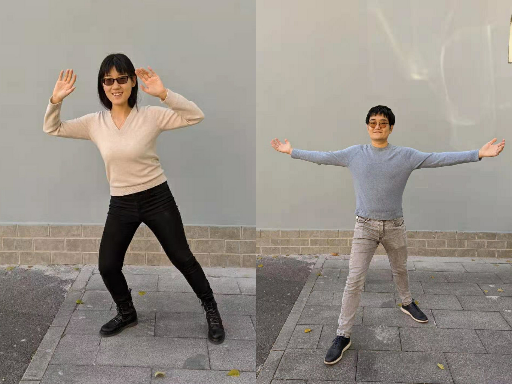

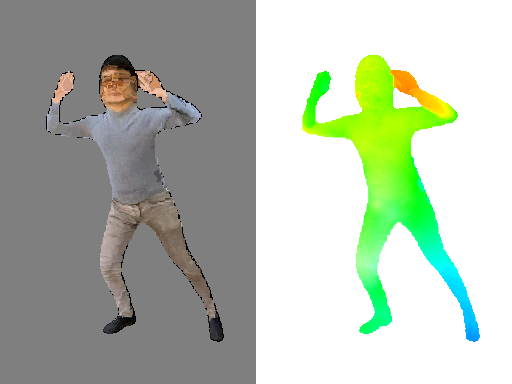

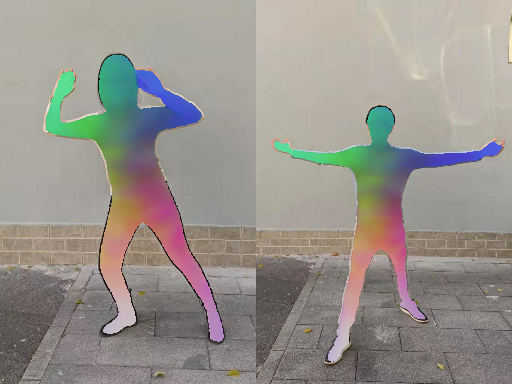

In [10]:
folder_path = './example_data/'
name1 ='im1'
name2 ='im3'

image_bgs, masks, features, image_summaries = inference(name1, name2)
foreground_feature1_vis, foreground_feature2_vis = visualize_feature_pca(features, masks)

warped_image = image_summaries['warped_image_search']
flow = image_summaries['flow_search']

image_bgs_vis = image_bgs.numpy().astype(np.uint8)
image1_bgs_vis = image_bgs_vis[0]
image2_bgs_vis = image_bgs_vis[1]
warped_image_vis = ((warped_image[0].numpy()*255)).astype(np.uint8)
flow_vis = ((flow[0].numpy()) * 255).astype(np.uint8)

feature1_bgs_vis = image1_bgs_vis.copy()
feature2_bgs_vis = image2_bgs_vis.copy()

feature1_bgs_vis[masks[0].numpy()] = foreground_feature1_vis
feature2_bgs_vis[masks[1].numpy()] = foreground_feature2_vis

image_bgs_vis = np.concatenate([image1_bgs_vis, image2_bgs_vis], axis=1)
warped_image_and_flow_vis = np.concatenate([warped_image_vis, flow_vis], axis=1)
feature_bgs_vis = np.concatenate([feature1_bgs_vis, feature2_bgs_vis], axis=1)

display(Image.fromarray(image_bgs_vis))
display(Image.fromarray(warped_image_and_flow_vis))
display(Image.fromarray(feature_bgs_vis))

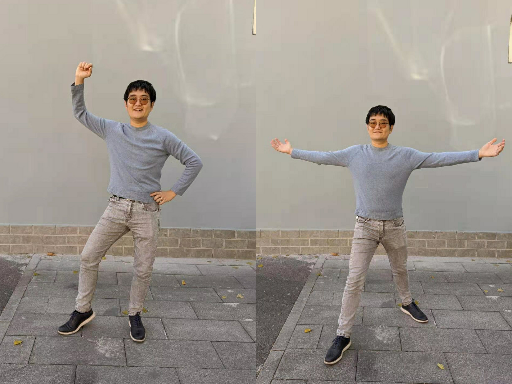

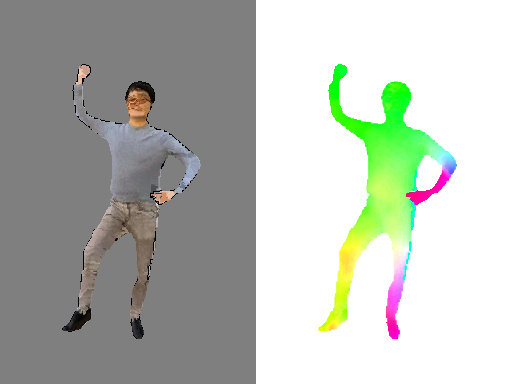

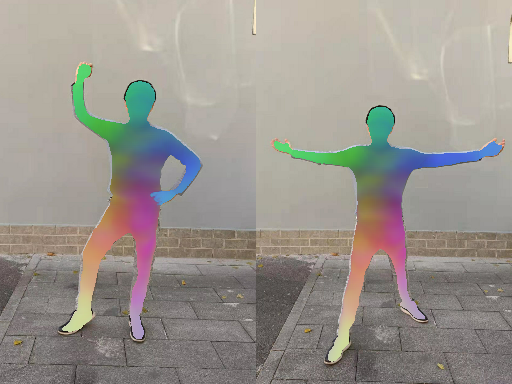

In [11]:
folder_path = './example_data/'
name1 ='im2'
name2 ='im3'

image_bgs, masks, features, image_summaries = inference(name1, name2)
foreground_feature1_vis, foreground_feature2_vis = visualize_feature_pca(features, masks)

warped_image = image_summaries['warped_image_search']
flow = image_summaries['flow_search']

image_bgs_vis = image_bgs.numpy().astype(np.uint8)
image1_bgs_vis = image_bgs_vis[0]
image2_bgs_vis = image_bgs_vis[1]
warped_image_vis = ((warped_image[0].numpy()*255)).astype(np.uint8)
flow_vis = ((flow[0].numpy()) * 255).astype(np.uint8)

feature1_bgs_vis = image1_bgs_vis.copy()
feature2_bgs_vis = image2_bgs_vis.copy()

feature1_bgs_vis[masks[0].numpy()] = foreground_feature1_vis
feature2_bgs_vis[masks[1].numpy()] = foreground_feature2_vis

image_bgs_vis = np.concatenate([image1_bgs_vis, image2_bgs_vis], axis=1)
warped_image_and_flow_vis = np.concatenate([warped_image_vis, flow_vis], axis=1)
feature_bgs_vis = np.concatenate([feature1_bgs_vis, feature2_bgs_vis], axis=1)

display(Image.fromarray(image_bgs_vis))
display(Image.fromarray(warped_image_and_flow_vis))
display(Image.fromarray(feature_bgs_vis))